# Importing libraries
First we are going to import the libraries

In [428]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import seaborn as sns
import math
from time import time
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn import tree
from sklearn import svm
from sklearn import linear_model
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, fbeta_score
from IPython.display import display # Allows the use of display() for DataFrames

# Pretty display for notebooks
%matplotlib inline

# Loading the data

In [429]:
train_file = './input/train.csv'
full_data_raw = pd.read_csv(train_file)

test_file = './input/test.csv'
kaggle_test_df = pd.read_csv(test_file)

# Print the first few entries of the RMS Titanic train data
display(full_data_raw.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


From a sample of the RMS Titanic data, we can see the various features present for each passenger on the ship:
- **Survived**: Outcome of survival (0 = No; 1 = Yes)
- **Pclass**: Socio-economic class (1 = Upper class; 2 = Middle class; 3 = Lower class)
- **Name**: Name of passenger
- **Sex**: Sex of the passenger
- **Age**: Age of the passenger (Some entries contain `NaN`)
- **SibSp**: Number of siblings and spouses of the passenger aboard
- **Parch**: Number of parents and children of the passenger aboard
- **Ticket**: Ticket number of the passenger
- **Fare**: Fare paid by the passenger
- **Cabin** Cabin number of the passenger (Some entries contain `NaN`)
- **Embarked**: Port of embarkation of the passenger (C = Cherbourg; Q = Queenstown; S = Southampton)

# Data Preparation and Exploration

Checking the condition of the dataset.

- Are there duplicated records?
- What are the data types?
- Are there NaN records?
- Is the dataset unbalanced?
- Are there categorical features? How many different values?
- Does the data have outliers?

**`Are there duplicated records?`**

In [430]:
full_data_raw[full_data_raw.duplicated()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


As we can see above, there **aren't duplicated values**.

**`What are the data types?`**

In [431]:
full_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


As we can see above, the data types are consistent with their meanings, except for the 'Age' feature which should be only integers. Let's check why the Pandas library is treating this feature as float64 type:

In [432]:
def check_age_floats(data):
    floats = []
    for i in data.Age.values:
        if i.is_integer() == False and not math.isnan(i):
            floats.append(i)
    data_age_floats = data[data.Age.isin(floats)]
    return data_age_floats

In [433]:
age_floats = check_age_floats(full_data_raw)
print('Total of {} float values'.format(len(age_floats)))

Total of 25 float values


Here are the data which correspond to these values:

In [434]:
age_floats

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
57,58,0,3,"Novel, Mr. Mansouer",male,28.50,0,0,2697,7.2292,NaN,C
78,79,1,2,"Caldwell, Master. Alden Gates",male,0.83,0,2,248738,29.0000,NaN,S
111,112,0,3,"Zabour, Miss. Hileni",female,14.50,1,0,2665,14.4542,NaN,C
116,117,0,3,"Connors, Mr. Patrick",male,70.50,0,0,370369,7.7500,NaN,Q
122,123,0,2,"Nasser, Mr. Nicholas",male,32.50,1,0,237736,30.0708,NaN,C
123,124,1,2,"Webber, Miss. Susan",female,32.50,0,0,27267,13.0000,E101,S
148,149,0,2,"Navratil, Mr. Michel (""Louis M Hoffman"")",male,36.50,0,2,230080,26.0000,F2,S
152,153,0,3,"Meo, Mr. Alfonzo",male,55.50,0,0,A.5. 11206,8.0500,NaN,S
153,154,0,3,"van Billiard, Mr. Austin Blyler",male,40.50,0,2,A/5. 851,14.5000,NaN,S
203,204,0,3,"Youseff, Mr. Gerious",male,45.50,0,0,2628,7.2250,NaN,C


There are values less than 1, for example 0.83 and 0.92. As the other features do not tell us more information if these values are correct, we are going to consider the whole the dataset.

This is an initial approach, and depending on the accuracy, we can try removing these records because they might be outliers or error on the data acquisition process.

**`Are there NaN records?`**

First, the train data:

In [435]:
full_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [436]:
print('There are {} NaN Age records on training data.'.format(len(full_data_raw[full_data_raw.Age.isna()==True])))
print('There are {} NaN Cabin records on training data.'.format(len(full_data_raw[full_data_raw.Cabin.isna()==True])))
print('There are {} NaN Embarked records on training data.'.format(len(full_data_raw[full_data_raw.Embarked.isna()==True])))

There are 177 NaN Age records on training data.
There are 687 NaN Cabin records on training data.
There are 2 NaN Embarked records on training data.


As we can see above, there are NaN values inside 'Age' feature, 'Cabin' feature and 'Embarked' feature.

As an initial approach for NaN records, we are going to remove the NaN inside the Age feature. We are not going to remove the Cabin NaN because they represent almost the entire dataset.

In [437]:
full_data_raw_droppedNan_age = full_data_raw.dropna(subset=['Age'])

In [438]:
full_data_raw_droppedNan_age.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    714 non-null int64
Survived       714 non-null int64
Pclass         714 non-null int64
Name           714 non-null object
Sex            714 non-null object
Age            714 non-null float64
SibSp          714 non-null int64
Parch          714 non-null int64
Ticket         714 non-null object
Fare           714 non-null float64
Cabin          185 non-null object
Embarked       712 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 72.5+ KB


Kaggle's test data:

In [439]:
kaggle_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [440]:
print('There are {} NaN Age records on training data.'.format(len(kaggle_test_df[kaggle_test_df.Age.isna()==True])))
print('There are {} NaN Fare records on training data.'.format(len(kaggle_test_df[kaggle_test_df.Fare.isna()==True])))
print('There are {} NaN Cabin records on training data.'.format(len(kaggle_test_df[kaggle_test_df.Cabin.isna()==True])))

There are 86 NaN Age records on training data.
There are 1 NaN Fare records on training data.
There are 327 NaN Cabin records on training data.


In [441]:
kaggle_test_df.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [442]:
values = {'Age': 30.272590, 'Fare': 35.627188}
kaggle_test_df.fillna(value=values, inplace=True)

**`Is the data unbalanced?`**

In [443]:
#The numbers below consider the dataset without the NaN records of the Age feature
#Number of people onboard
n_examples = len(full_data_raw_droppedNan_age.index)

#Number of people who survived
n_survived= full_data_raw_droppedNan_age[full_data_raw_droppedNan_age['Survived']==1].shape[0]

#Number of people who didn't survive
n_didnt_survived = n_examples-n_survived

#Percentage of people who survived
greater_percent = (n_survived/n_examples)*100

# Print the results
print("Total number of people: {}".format(n_examples))
print("Individuals who survived: {}".format(n_survived))
print("Individuals who didn't survive: {}".format(n_didnt_survived))
print("Percentage of individuals who survived: {}%".format(greater_percent))

Total number of people: 714
Individuals who survived: 290
Individuals who didn't survive: 424
Percentage of individuals who survived: 40.61624649859944%


So, the dataset is slightly unbalanced (**40%/60%**).

**`Are there categorical features? How many different values?`**

In [444]:
full_data_raw_droppedNan_age.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    714 non-null int64
Survived       714 non-null int64
Pclass         714 non-null int64
Name           714 non-null object
Sex            714 non-null object
Age            714 non-null float64
SibSp          714 non-null int64
Parch          714 non-null int64
Ticket         714 non-null object
Fare           714 non-null float64
Cabin          185 non-null object
Embarked       712 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 72.5+ KB


As we can see, the categorial features are: Name, Sex, Ticket, Cabin and Embarked.

In [445]:
print('There are: \n{} different Name values'.format(len(full_data_raw_droppedNan_age.Name.value_counts())))
print('{} different Sex values'.format(len(full_data_raw_droppedNan_age.Sex.value_counts())))
print('{} different Ticket values'.format(len(full_data_raw_droppedNan_age.Ticket.value_counts())))
print('{} different Cabin values'.format(len(full_data_raw_droppedNan_age.Cabin.value_counts())))
print('{} different Embarked values'.format(len(full_data_raw_droppedNan_age.Embarked.value_counts())))

There are: 
714 different Name values
2 different Sex values
542 different Ticket values
134 different Cabin values
3 different Embarked values


As we can see, there are many different values for the features, except for Sex and Embarked. By intuition, these are important features for our classifier. So, we need to encode at least these features.

We are going to use one hot encoding as an initial approach for only Sex and Embarked features. The other features (Name, Ticket and Cabin) **are not going to be considered in this initial approach**.

In [446]:
#One hot encoding on the train data:
full_data_raw_droppedNan_age_numerical = pd.get_dummies(data=full_data_raw_droppedNan_age , columns=['Sex','Embarked'])
full_data_raw_droppedNan_age_numerical.head(3)

#One hot encoding on the Kaggle's test data:
kaggle_test_df = pd.get_dummies(data=kaggle_test_df , columns=['Sex','Embarked'])

#Removing the features which are not going to be considered for now:
full_data_raw_droppedNan_age_numerical = full_data_raw_droppedNan_age_numerical.drop(columns=['Name','Ticket', 'Cabin'])

#Also removing these features from the Kaggle's test data:
kaggle_test_df = kaggle_test_df.drop(columns=['Name','Ticket', 'Cabin'])

**`Does the numerical data have outliers?`**

In [447]:
full_data_raw_droppedNan_age_numerical.drop(columns=['Survived', 'PassengerId']).describe()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
count,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000
mean,2.236695,29.699118,0.512605,0.431373,34.694514,0.365546,0.634454,0.182073,0.039216,0.775910
std,0.838250,14.526497,0.929783,0.853289,52.918930,0.481921,0.481921,0.386175,0.194244,0.417274
min,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,20.125000,0.000000,0.000000,8.050000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2.000000,28.000000,0.000000,0.000000,15.741700,0.000000,1.000000,0.000000,0.000000,1.000000
75%,3.000000,38.000000,1.000000,1.000000,33.375000,1.000000,1.000000,0.000000,0.000000,1.000000
max,3.000000,80.000000,5.000000,6.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000


In [448]:
kaggle_test_df.drop(columns=['PassengerId']).describe()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,2.265550,30.272590,0.447368,0.392344,35.627188,0.363636,0.636364,0.244019,0.110048,0.645933
std,0.841838,12.634534,0.896760,0.981429,55.840500,0.481622,0.481622,0.430019,0.313324,0.478803
min,1.000000,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,23.000000,0.000000,0.000000,7.895800,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,30.272590,0.000000,0.000000,14.454200,0.000000,1.000000,0.000000,0.000000,1.000000
75%,3.000000,35.750000,1.000000,0.000000,31.500000,1.000000,1.000000,0.000000,0.000000,1.000000
max,3.000000,76.000000,8.000000,9.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000


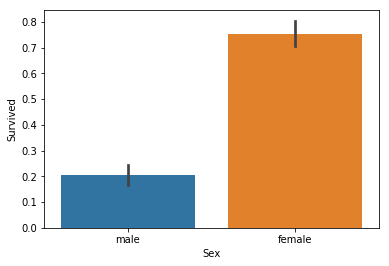

In [449]:
sns.barplot(data=full_data_raw_droppedNan_age, x='Sex', y='Survived')

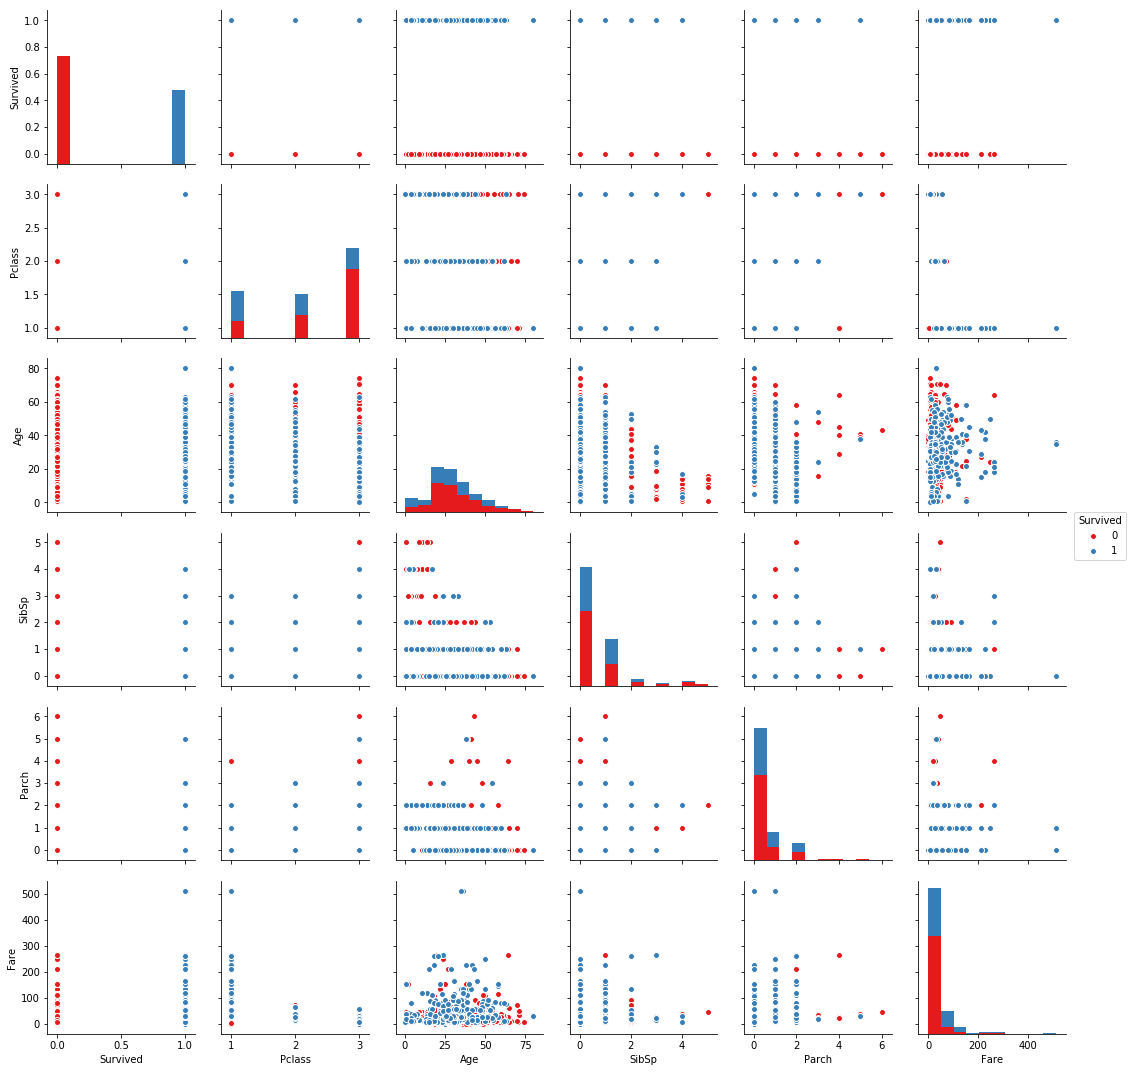

In [450]:
sns.pairplot(data=full_data_raw_droppedNan_age.drop(columns=['PassengerId']), palette='Set1',hue='Survived' )

# Data split - Train, Test

**`Storing the labels using the 'outcomes' variable:`**

In [451]:
# Store the 'Survived' feature in a new variable and remove it from the train dataset
outcomes = full_data_raw_droppedNan_age_numerical['Survived']
data_raw = full_data_raw_droppedNan_age_numerical.drop('Survived', axis = 1)

# Show the new dataset with 'Survived' removed
display(data_raw.head(1))

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,3,22.0,1,0,7.25,0,1,0,0,1


We can see above that the PassengerId is still inside our input dataframe. This can be a problem because the PassengerIds of the Kaggle's test dataset are bigger numbers than the train dataset, as we can see below. This can be a problem to the model. Moreover, by intuition we can assume that the Ids are not features which can give us information about the survival. So, we are also removing this feature:

In [452]:
kaggle_test_df.head(1)

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,892,3,34.5,0,0,7.8292,0,1,0,1,0


In [453]:
data_raw = data_raw.drop('PassengerId', axis = 1)
kaggle_test_df_without_Ids = kaggle_test_df.drop('PassengerId', axis = 1)

Data variables dictionary:
- **full_data_raw**: The full input raw data
- **full_data_raw_droppedNan_age**: full_data_raw dropped NaN from 'Age' feature
- **full_data_raw_droppedNan_age_numerical**: full_data_raw_droppedNan_age with Sex and Embarked features encoded
- **data_raw**: full_data_raw_droppedNan_age_numerical without the label 'Survived'
- **outcomes**: The label 'Survived' for each example

**`Splitting in train and test:`**

In [454]:
X_train, X_test, y_train, y_test = train_test_split(data_raw, 
                                                    outcomes, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 571 samples.
Testing set has 143 samples.


# Naive Predictor

If we were asked to make a prediction about any passenger aboard the RMS Titanic whom we knew nothing about, then the best prediction we could make would be that they did not survive. This is because we can assume that a majority of the passengers (more than 50%) did not survive the ship sinking.
The `naive_predictor` function below will always predict that a passenger did not survive.

In [455]:
def naive_predictor(data):
    """ Model with no features. Always predicts a passenger did not survive. """

    predictions = []
    for _, passenger in data.iterrows():
        
        # Predict the survival of 'passenger'
        predictions.append(0)
    
    # Return our predictions
    return pd.Series(predictions)

**`Accuracy score of the naive predictor:`**

In [456]:
predictions = naive_predictor(data_raw)
naive_accuracy = accuracy_score(outcomes, predictions)
print("Naive Predictor: [Accuracy score: {:.4f}]".format(naive_accuracy))

Naive Predictor: [Accuracy score: 0.5938]


# Training and Predicting

In [457]:
def create_learner_results(learner, X_train, y_train, X_test, y_test):
    results = {}
    #learner = learner.fit(X_train,y_train)
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
            
    results['acc_train'] = accuracy_score(y_true=y_train, y_pred=predictions_train)
    results['acc_test'] = accuracy_score(y_true=y_test, y_pred=predictions_test)
    sample_size=len(X_train)
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
    return results

In [458]:
clf_A = tree.DecisionTreeClassifier()
clf_B = linear_model.LogisticRegression()
clf_C = AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(max_depth=1))

parameters_A = {'max_depth': range(1,10), 'min_samples_split': range(4,10), 'max_leaf_nodes': range(2,12)}
parameters_B = {'max_iter': range(50,150,10)}
parameters_C = {'base_estimator__max_depth': [1,2,3], 'learning_rate': [0.01,0.1,0.5,0.8,1.0], 'n_estimators':range(30,70,10)}

scorer = make_scorer(score_func=accuracy_score)

#Decision Tree
grid_obj = GridSearchCV(estimator=clf_A, param_grid=parameters_A, scoring=scorer)
grid_fit = grid_obj.fit(X_train, y_train)
best_clf_A = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf_A.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf_A.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized Decision Tree model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("\nOptimized Decision Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
best_accuracy = accuracy_score(y_test, best_predictions)
final_model = best_clf_A

#Logistic Regression
grid_obj = GridSearchCV(estimator=clf_B, param_grid=parameters_B, scoring=scorer)
grid_fit = grid_obj.fit(X_train, y_train)
best_clf_B = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf_B.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf_B.predict(X_test)

# Report the before-and-afterscores
print("\n\nUnoptimized Logistic Regression model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("\nOptimized Logistic Regression Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
if accuracy_score(y_test, best_predictions) > best_accuracy:
    best_accuracy = accuracy_score(y_test, best_predictions)
    final_model = best_clf_B

#AdaBoost Classifier
grid_obj = GridSearchCV(estimator=clf_C, param_grid=parameters_C, scoring=scorer)
grid_fit = grid_obj.fit(X_train, y_train)
best_clf_C = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf_C.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf_C.predict(X_test)

# Report the before-and-afterscores
print("\n\nUnoptimized Adaboost model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("\nOptimized Adaboost Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
if accuracy_score(y_test, best_predictions) > best_accuracy:
    best_accuracy = accuracy_score(y_test, best_predictions)
    final_model = best_clf_C

Unoptimized Decision Tree model
------
Accuracy score on testing data: 0.7622

Optimized Decision Model
------
Final accuracy score on the testing data: 0.7832


Unoptimized Logistic Regression model
------
Accuracy score on testing data: 0.8252

Optimized Logistic Regression Model
------
Final accuracy score on the testing data: 0.8252


Unoptimized Adaboost model
------
Accuracy score on testing data: 0.8182

Optimized Adaboost Model
------
Final accuracy score on the testing data: 0.8392


In [459]:
def evaluate(results, naive_accuracy):
    """
    Visualization code to display results of various learners.
    
    inputs:
      - learners: a list of supervised learners
      - stats: a list of dictionaries of the statistic results from 'train_predict()'
      - accuracy: The score for the naive predictor
    """
    # Create figure
    fig, ax = plt.subplots(ncols=2, figsize = (10,5))

    # Constants
    bar_width = 0.3
    colors = ['#A00000','#00A0A0','#00A000']
    
    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['acc_train', 'acc_test']):
            for i in np.arange(3):
                # Creative plot code
                ax[j%3].bar(i+k*bar_width, results[learner][metric], width = bar_width, color = colors[k])
                ax[j%3].set_xticks([0.45, 1.45, 2.45])
                ax[j%3].set_xlim((-0.1, 3.0))
    
    # Add unique y-labels
    ax[0].set_ylabel("Accuracy Score")
    ax[1].set_ylabel("Accuracy Score")
    
    # Add titles
    ax[0].set_title("Accuracy Score on Training Subset")
    ax[1].set_title("Accuracy Score on Testing Set")
    
    # Add horizontal lines for naive predictors
    ax[0].axhline(y = naive_accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1].axhline(y = naive_accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    
    # Set y-limits for score panels
    ax[0].set_ylim((0, 1))
    ax[1].set_ylim((0, 1))

    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    plt.legend(handles = patches, bbox_to_anchor = (0.5, 1.3), loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'medium')
    
    plt.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 14, y = 1)
    plt.show()

DecisionTreeClassifier trained on 571 samples.
LogisticRegression trained on 571 samples.
AdaBoostClassifier trained on 571 samples.


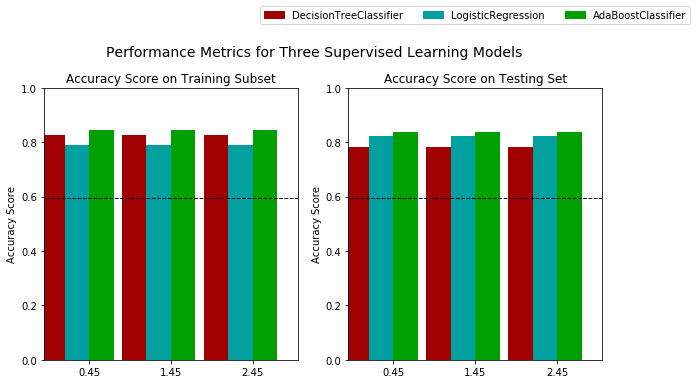

In [460]:
# Collect results on the learners
results = {}
for clf in [best_clf_A, best_clf_B, best_clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    results[clf_name] = create_learner_results(clf, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
evaluate(results, naive_accuracy)

# Creating Submission file

In [461]:
final_model

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.01, n_estimators=60, random_state=None)

In [462]:
submission_predictions = final_model.predict(kaggle_test_df_without_Ids)
submission_df = pd.DataFrame({'PassengerId':kaggle_test_df['PassengerId'],'Survived':submission_predictions})

filename = './output/Titanic_Predictions_1.csv'

submission_df.to_csv(filename,index=False)

print('Saved file: ' + filename)

Saved file: ./output/Titanic_Predictions_1.csv


Approaches:

-Use average age and standard deviation

-Use other features to predict the Age for the NaNs